In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error

In [35]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)]  # MB
        )
        print("VRAM limited to 10000 MB.")
    except RuntimeError as e:
        print("Memory configuration must be set at program start:", e)

VRAM limited to 10000 MB.


In [36]:
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    
    # Drop last 6 rows
    df = df.iloc[:-6]
    
    # Convert date column to datetime
    df['#date+time'] = pd.to_datetime(df['#date+time'], errors='coerce')
    df = df.rename(columns={'#date+time': 'date_time'})
    
    # Convert all other columns to numeric
    for col in df.columns:
        if col != 'date_time':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df
def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)
    # This converts FROM meteorological TO Cartesian
    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

def prepare_dataframe(df):
    # Rename columns to a consistent format

    df = df.rename(columns={
        df.columns[0]: 'date_time',
        df.columns[1]: 'pwl',
        df.columns[2]: 'harmwl',
        df.columns[3]: 'wsd',  # Wind speed
        df.columns[4]: 'wdr',  # Wind direction
    })
    
    # Convert wind to U/V components
    u, v = wind_to_uv(df['wsd'], df['wdr'])
    df[['u', 'v']] = np.column_stack((u, v))
    
    # Drop raw wind columns
    df.drop(columns=['wsd', 'wdr','harmwl'], inplace=True)
    
    return df

def input_output_arrays(source_df, target_df, target_hourly_wind_df, wl_half_window=5, wind_window=3):

    source_df = source_df.reset_index(drop=True)
    target_df = target_df.reset_index(drop=True)

    # Extract arrays
    pl_pwl = source_df['pwl'].to_numpy()
    target_pwl = target_df['pwl'].to_numpy()
    datetimes = source_df['date_time'].to_numpy()

    # Convert hourly wind df to dictionary for fast lookup
    wind_lookup = {
        ts: (row['u'], row['v']) for ts, row in target_hourly_wind_df.set_index('date_time')[['u', 'v']].iterrows()
    }

    X, y, indices = [], [], []
    for t in range(wl_half_window, len(source_df) - wl_half_window):
        curr_time = datetimes[t]

        # Water level input
        pwl_input = pl_pwl[t - wl_half_window: t + wl_half_window + 1]
        if np.isnan(pwl_input).any():
            continue

        # Hourly wind input timestamps
        hourly_times = [(curr_time - pd.Timedelta(hours=i)).replace(minute=0, second=0, microsecond=0)
                        for i in reversed(range(wind_window))]

        try:
            uv_values = np.array([wind_lookup[ts] for ts in hourly_times]).flatten()
        except KeyError:
            continue  # skip if any timestamp is missing

        target = target_pwl[t]
        if np.isnan(uv_values).any() or np.isnan(target):
            continue

        X.append(np.concatenate([pwl_input, uv_values]))
        y.append(target)
        indices.append(t)

    return np.array(X), np.array(y), np.array(indices)


def calculate_central_frequency_percentage(testing_label_array, predictions, cm):
  """Find the percentage of predictions with a central frequency (CF) of less than
  or equal to a given number of centimeters (cm)

	Args:
        testing_label_array (array): Testing labels

        predictions (array): Model predictions

        cm (int): Number of centimeters

	Returns:
		(float): central frequency (CF) percentage
	"""
  less_than_cm_counter = 0

  # Convert cm to m
  cm_to_m = cm / 100

  for index, prediction in enumerate(predictions):
    if abs(testing_label_array[index] - prediction) <= cm_to_m:
      less_than_cm_counter += 1

  cf_percentage = (less_than_cm_counter / len(predictions)) * 100

  return cf_percentage


def evaluate_model(model, testing_input_array, testing_label_array):
  """Calculates loss, makes predictions, and calculates Central Frequency (CF),
  Mean Squared Error (MSE), Root Mean Squared Error(RMSE), Mean Absolute Error (MAE),
  Median Absolute Error, and R-squared (R2)

	Args:
        model (tf.keras.model): The trained model

        testing_input_array (array): Testing inputs

        testing_label_array (array): Testing labels
	"""
  print("Calculating Loss:")
  test_loss = model.evaluate(testing_input_array, testing_label_array, batch_size = len(testing_input_array))

  print("Loss:", test_loss)


  print("\nGenerating output predictions with model:")
  predictions = model.predict(testing_input_array, batch_size = len(testing_input_array))

  # Calculate evaluation metrics
  cf_15cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 15)
  cf_5cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 5)
  cf_1cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 1)
  mse = mean_squared_error(testing_label_array, predictions)
  rmse = root_mean_squared_error(testing_label_array, predictions)
  mae = mean_absolute_error(testing_label_array, predictions)
  medae = median_absolute_error(testing_label_array, predictions)
  r2 = r2_score(testing_label_array, predictions)

  print("\nCentral Frequency Percentage 15cm:", cf_15cm_percentage)
  print("\nCentral Frequency Percentage 5cm:", cf_5cm_percentage)
  print("\nCentral Frequency Percentage 1cm:", cf_1cm_percentage)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("Mean Absolute Error:", mae)
  print("Median Absolute Error:", medae)
  print("R-squared:", r2)


file_paths = {
    'pi08': '/home/ryan/Downloads/pIsabel_pwl+wind_june2008-2009.csv',
    'cg08': '/home/ryan/Downloads/spiCoastGuard_pwl+wind+surge_june2008-2009.csv',
    'pi09': '/home/ryan/Downloads/pIsabel_pwl+wind+surge_mar2009-apr2010.csv',
    'cg09': '/home/ryan/Downloads/spiCoastGuard_pwl+wind+surge_mar2009-apr2010.csv',
    'pi11': '//home/ryan/Downloads/pIsabel_pwl+wind+surge_mar2011-apr2012.csv',
    'cg11': '/home/ryan/Downloads/spiCoastGuard_pwl+wind+surge_mar2011-apr2012.csv',

}

datasets = {key: load_and_clean_csv(path) for key, path in file_paths.items()}

for name, df in datasets.items():
    datasets[name] = prepare_dataframe(df)


In [37]:
for key in ['cg08', 'cg09', 'cg11']:
    df = datasets[key].copy()
    
    # Floor datetimes to the hour
    df['hour'] = df['date_time'].dt.floor('H')
    
    # Group by hourly bins and compute nanmean for u and v
    hourly_avg = df.groupby('hour')[['u', 'v']].agg(np.nanmean).reset_index()
    
    # Rename 'hour' back to 'date_time' to match expected column
    hourly_avg.rename(columns={'hour': 'date_time'}, inplace=True)
    
    datasets[f'{key}_uv_hourly'] = hourly_avg

/tmp/ipykernel_1143849/586016251.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['date_time'].dt.floor('H')
/tmp/ipykernel_1143849/586016251.py:8: FutureWarning: The provided callable <function nanmean at 0x75c095bb1a80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  hourly_avg = df.groupby('hour')[['u', 'v']].agg(np.nanmean).reset_index()
/tmp/ipykernel_1143849/586016251.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['date_time'].dt.floor('H')
/tmp/ipykernel_1143849/586016251.py:8: FutureWarning: The provided callable <function nanmean at 0x75c095bb1a80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string 

In [69]:
X_train, y_train, indices_train = input_output_arrays(datasets['cg08'], datasets['pi08'],datasets['cg08_uv_hourly'], wl_half_window=30, wind_window=3)

X_valid, y_valid, indices_valid = input_output_arrays(datasets['cg09'], datasets['pi09'], datasets['cg09_uv_hourly'], wl_half_window=30, wind_window=3)

X_test, y_test, indices_test = input_output_arrays(datasets['cg11'], datasets['pi11'], datasets['cg11_uv_hourly'], wl_half_window=30, wind_window=3)

print(X_train.shape, y_train.shape)


(69257, 67) (69257,)


In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(1, kernel_initializer = 'normal' ))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [86]:
epochs = 1000

batch_size = len(X_train)
val_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)

file_name = 'nev_test.keras'
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [early_stopping, checkpoint]

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=epochs,
    batch_size=batch_size,
    validation_batch_size=val_batch_size,
    callbacks=callbacks,
    verbose=1
)

model.summary()

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.5507 - mae: 1.5755
Epoch 1: val_loss improved from inf to 2.27419, saving model to nev_test.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.5507 - mae: 1.5755 - val_loss: 2.2742 - val_mae: 1.4892
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3152 - mae: 1.4995
Epoch 2: val_loss improved from 2.27419 to 2.05575, saving model to nev_test.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.3152 - mae: 1.4995 - val_loss: 2.0558 - val_mae: 1.4140
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0956 - mae: 1.4248
Epoch 3: val_loss improved from 2.05575 to 1.84998, saving model to nev_test.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.0956 - mae: 1.4248 - val_loss: 1.8500 - val_mae: 1.3392
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8862 - mae: 1.3496
Epoch 4: val_loss improved from 1.84998 to 1.65683, saving model to nev_test.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 20)             │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,145 (16.20 KB)

 Trainable params: 1,381 (5.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,764 (10.80 KB)

In [90]:
evaluate_model(model, X_test, y_test)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0015 - mae: 0.0306
Loss: [0.0015111059183254838, 0.030567094683647156]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Central Frequency Percentage 15cm: 99.68689656677176

Central Frequency Percentage 5cm: 78.69805701318961

Central Frequency Percentage 1cm: 23.69876613246348
Mean Squared Error: 0.0015111058814669305
Root Mean Squared Error: 0.038872945366500475
Mean Absolute Error: 0.03056709516355744
Median Absolute Error: 0.02629817485809327
R-squared: 0.9456712055158418


In [91]:

predictions = model.predict(X_test, batch_size=len(X_test))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


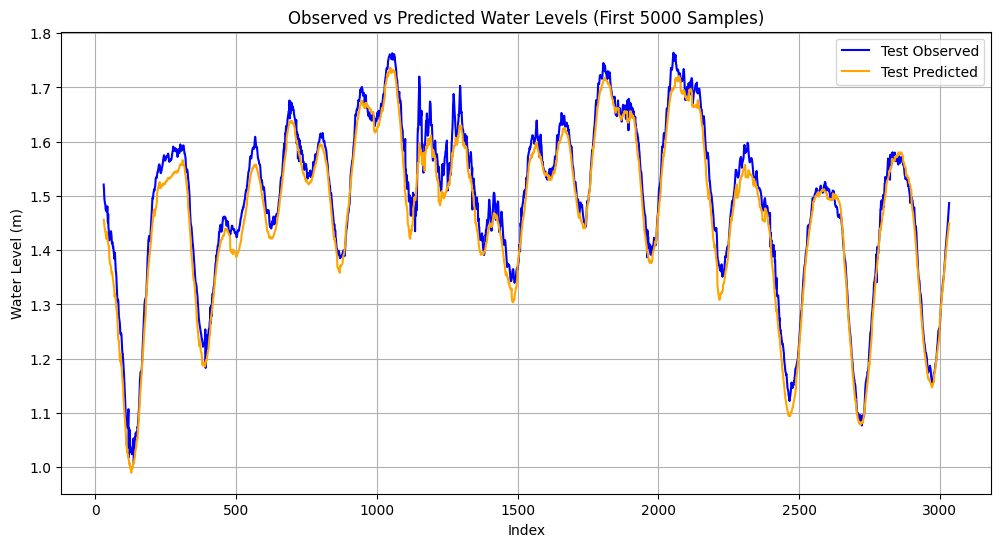

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(indices_test[:3000], y_test[:3000], label='Test Observed', color='blue')
plt.plot(indices_test[:3000], predictions[:3000], label='Test Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Water Level (m)')
plt.title('Observed vs Predicted Water Levels (First 5000 Samples)')
plt.legend()
plt.grid()
plt.show()